I. Towards writing clear instructions

4. Steps...

In [1]:
from openai import OpenAI
import pandas as pd
df = pd.read_csv('verbs3.csv')
client = OpenAI()

def p2_translate_(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [
            {"role": "system", "content": 
                "نتا خبير فلهجة الدارجة المغربية وفالترجمة من الدارجة لنجليزية. " + 
                "الخطوة 1 - غادي نعطيك واحد الفعل بالدارجة المغربية، والمهمة ديالك هي تترجمو لفعل انجليزي. " +
                "الخطوة 2 - خود الفعل المترجم من الخطوة 1 وخرج غير جذر الفعل المترجم بلا تفسيرات. "                
             },
            {"role": "user", "content": f"{verb}"}
        ],
        temperature=0
    )
    return completion.choices[0].message.content
def eng_p2_translate_(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [
            {"role": "system", "content": 
             "You are an expert in Language translation from Moroccan Darija dialect to English. " +
             "Use the following step-by-step instructions to respond to the user input."
             "Step 1 - You will be provided with a verb in Moroccan Darija language, and your task is to translate it into a English verb. "
             "Step 2 - Take the translated verb from Step 1 and output only its lemma with no explanations."},
            {"role": "user", "content": f"{verb}"},
        ],
        temperature=0
    )
    return completion.choices[0].message.content
df.columns

Index(['darija_ar', 'eng', 'p1_transl', 'eng_p1_transl', 'p2_transl',
       'eng_p2_transl', 'p3_transl', 'eng_p3_transl'],
      dtype='object')

In [3]:
dataset = df.copy()
columns_to_delete = ['p1_transl', 'eng_p1_transl', 'p3_transl', 'eng_p3_transl']
dataset.drop(columns=columns_to_delete, inplace=True)
print(dataset.columns)
dataset.columns = ['darija_ar', 'eng', 'p1_transl', 'eng_p1_transl']
dataset.columns

Index(['darija_ar', 'eng', 'p2_transl', 'eng_p2_transl'], dtype='object')


Index(['darija_ar', 'eng', 'p1_transl', 'eng_p1_transl'], dtype='object')

In [4]:
dataset['p2_transl'] = dataset['darija_ar'].apply(p2_translate_)
dataset['eng_p2_transl'] = dataset['darija_ar'].apply(eng_p2_translate_)

In [5]:
dataset.to_csv('verbs4.csv', index=False)

In [6]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
import pandas as pd
dataset = pd.read_csv('verbs4.csv')

eng = dataset['eng']
eng = [verb.replace(" ", "_") for verb in eng]
p1_transl = dataset['p1_transl']
eng_p1_transl = dataset['eng_p1_transl']
p2_transl = dataset['p2_transl']
eng_p2_transl = dataset['eng_p2_transl']


p1_transl = [verb.replace(" ", "_") for verb in p1_transl]
eng_p1_transl = [verb.replace(" ", "_") for verb in eng_p1_transl]
p2_transl = [verb.replace(" ", "_") for verb in p2_transl]
eng_p2_transl = [verb.replace(" ", "_") for verb in eng_p2_transl]


def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score

def evaluate_pairs(transl,threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results



results_p1 = evaluate_pairs(p1_transl)
results_eng_p1 = evaluate_pairs(eng_p1_transl)
results_p2 = evaluate_pairs(p2_transl)
results_eng_p2 = evaluate_pairs(eng_p2_transl)


dataset['similarity_p1'] = [item[2] for item in results_p1]
dataset['similarity_eng_p1'] = [item[2] for item in results_eng_p1]
dataset['similarity_p2'] = [item[2] for item in results_p2]
dataset['similarity_eng_p2'] = [item[2] for item in results_eng_p2]



p1_s = dataset['similarity_p1']
ep1_s = dataset['similarity_eng_p1']
p1= dataset['similarity_p1'].mean()
ep1= dataset['similarity_eng_p1'].mean()
p2_s = dataset['similarity_p2']
ep2_s = dataset['similarity_eng_p2']
p2= dataset['similarity_p2'].mean()
ep2= dataset['similarity_eng_p2'].mean()


print(f'Mean value of similarities in the first darija prompt is: {p1}')
print(f'Mean value of similarities in the first english prompt is: {ep1}')
print(f'Mean value of similarities in the second darija prompt is: {p2}')
print(f'Mean value of similarities in the second english prompt is: {ep2}')
dataset.describe()

Mean value of similarities in the first darija prompt is: 0.5908058913308915
Mean value of similarities in the first english prompt is: 0.5937832722832722
Mean value of similarities in the second darija prompt is: 0.5677781135531136
Mean value of similarities in the second english prompt is: 0.5826578754578754


,similarity_p1,similarity_eng_p1,similarity_p2,similarity_eng_p2
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.590806,0.593783,0.567778,0.582658
std,0.377403,0.382532,0.378939,0.393425
min,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.250000,0.250000,0.250000
50%,0.500000,0.500000,0.500000,0.500000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [7]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Box(y=dataset['similarity_p1'], name='Darija first prompt'))
fig.add_trace(go.Box(y=dataset['similarity_eng_p1'], name='english first prompt'))
fig.add_trace(go.Box(y=dataset['similarity_p2'], name='darija second prompt'))
fig.add_trace(go.Box(y=dataset['similarity_eng_p2'], name='english second prompt'))
# Update layout
fig.update_layout(
    title='Box Plot of Similarity Scores for all the prompts.',
    yaxis_title='Similarity Score',
    xaxis_title='Prompt',
    boxmode='group'  # group the box plots together
)

# Show plot
fig.show()

In [8]:
import plotly.graph_objects as go


fig = go.Figure()

fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_p1'], x=dataset['similarity_p1'], name="Count of similarities in first Darija prompt"))
fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_p2'], x=dataset['similarity_p2'], name="Count of similarities in second Darija prompt"))

fig.show()

In [9]:
import plotly.graph_objects as go


fig = go.Figure()

fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_eng_p1'], x=dataset['similarity_eng_p1'], name="Count of similarities in first English prompt"))
fig.add_trace(go.Histogram(histfunc="count", y=dataset['similarity_eng_p2'], x=dataset['similarity_eng_p2'], name="Count of similarities in second English prompt"))

fig.show()

In [10]:
from scipy.stats import ttest_ind, ttest_rel


# Interpretation
def ind_t_test(groups, percentage1, percentage2):
    t_stat, p_value = ttest_ind(percentage1, percentage2)
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print(f"The difference between the two sets of path similarity percentages between {groups} is statistically significant.\n")
    else:
        print(f"The difference between the two sets of path similarity percentages between {groups} is not statistically significant.\n")

def paired_t_test(groups, percentage1, percentage2):
    t_stat, p_value = ttest_rel(percentage1, percentage2)
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print(f"The difference between the two sets of path similarity percentages between {groups} is statistically significant.\n")
    else:
        print(f"The difference between the two sets of path similarity percentages between {groups} is not statistically significant.\n")

groups1 = 'English and Darija in the first prompt'
groups2 = 'English and Darija in the second prompt'

groups3 = 'Darija first and second prompt'
groups4 = 'English first and second prompt'

ind_t_test(groups1,p1_s,ep1_s)
ind_t_test(groups2,p2_s,ep2_s)

paired_t_test(groups3,p1_s,p2_s)

paired_t_test(groups4,ep1_s,ep2_s)


T-statistic: -0.17521163856712688
P-value: 0.8609310930999269
The difference between the two sets of path similarity percentages between English and Darija in the first prompt is not statistically significant.

T-statistic: -0.8614157585615758
P-value: 0.38911246522243137
The difference between the two sets of path similarity percentages between English and Darija in the second prompt is not statistically significant.

T-statistic: 2.810320767452846
P-value: 0.005045903502131348
The difference between the two sets of path similarity percentages between Darija first and second prompt is statistically significant.

T-statistic: 1.2550151969313594
P-value: 0.20976674765762401
The difference between the two sets of path similarity percentages between English first and second prompt is not statistically significant.



similarity_p2  0.000000  0.071429  0.076923  0.083333  0.100000  0.125000  \
similarity_p1                                                               
0.000000             17         0         0         0         0         0   
0.071429              0         1         0         0         0         0   
0.076923              0         0         1         0         0         0   
0.083333              0         0         0         1         0         0   
0.111111              0         0         0         0         0         0   
0.125000              0         0         0         0         0         4   
0.142857              2         0         0         0         0         0   
0.166667              3         0         0         0         2         0   
0.200000              4         0         0         0         0         0   
0.250000              7         0         0         0         0         0   
0.333333              5         0         0         1         0         0   

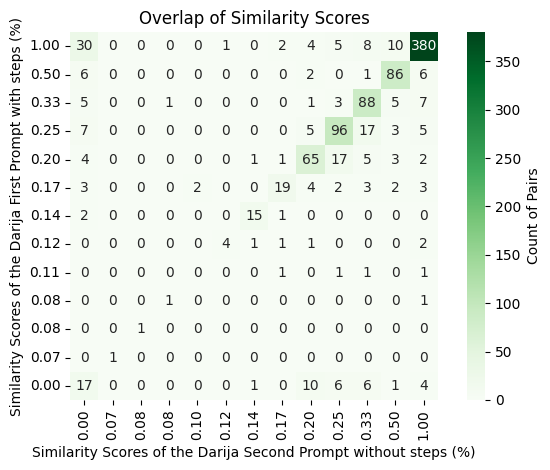

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dataset['triple_verbs'] = dataset['eng'] + ', ' + dataset['p1_transl'] + ', ' + dataset['p2_transl']

# Add Index Column
#dataset["index"] = dataset["eng"] + "-" + dataset["translations_prompt1"]
dataset["index"] = dataset["triple_verbs"]

dataset.set_index("index", inplace=True)

# Create Pivot Table
piv = pd.pivot_table(dataset, values="triple_verbs", index=["similarity_p1"], columns=["similarity_p2"], aggfunc='count', fill_value=0)
print(piv)


# Format similarity scores to two decimal places
piv.index = piv.index.map(lambda x: f'{x:.2f}')
piv.columns = piv.columns.map(lambda x: f'{x:.2f}')


ax = sns.heatmap(piv, square=True, annot=True, fmt="d", cbar_kws={'label': 'Count of Pairs'}, cmap="Greens")
plt.xlabel('Similarity Scores of the Darija Second Prompt without steps (%)')
plt.ylabel('Similarity Scores of the Darija First Prompt with steps (%)')
plt.title('Overlap of Similarity Scores')
plt.gca().invert_yaxis()  # Reverse y-axis
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()

SYSTEM
Use the following step-by-step instructions to respond to user inputs.

Step 1 - The user will provide you with text in triple quotes. Summarize this text in one sentence with a prefix that says "Summary: ".

Step 2 - Translate the summary from Step 1 into Spanish, with a prefix that says "Translation: ".

USER
"""insert text here"""
